# Deep Learning Model 

First Deep Learning model. The goal is to train a model that i can later apply for other projects. 

Dataset is Watkins Marine Mammal dataset.

The goal of the model is ...




---




Of all data we'll use:
- 70% for training
- 15% for validation
- 15% for test

## Setting up

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import random
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim

In [47]:
ROOT_PATH = Path("..")  
sys.path.append(str(ROOT_PATH))
from src.dataloaders import get_dataloaders
from src.model import EfficientNetSpectrogram
from src.model import BaselineCNN

from src.train import Trainer

In [48]:
AUDIO_DIR = ROOT_PATH / "Data" / "Audio"
ANNOT_DIR = ROOT_PATH / "Data" / "Annotations"
SPECT_DIR = ROOT_PATH / "Data" / "Spectrograms"

ANNOT_FILE = ANNOT_DIR / "audio_annotations.csv"

train_df = pd.read_csv(ANNOT_DIR / "train.csv")
val_df   = pd.read_csv(ANNOT_DIR / "val.csv")
test_df  = pd.read_csv(ANNOT_DIR / "test.csv")

## Showcase

In [49]:
df = pd.read_csv(ANNOT_FILE)
print(len(df))
print("Train:", len(train_df))
print("Val:  ", len(val_df))
print("Test: ", len(test_df))

15407
Train: 10784
Val:   2311
Test:  2312


SpermWhale ---  shape: (1, 128, 768)
Short_Finned(Pacific)PilotWhale ---  shape: (1, 128, 80)
SpinnerDolphin ---  shape: (1, 128, 288)


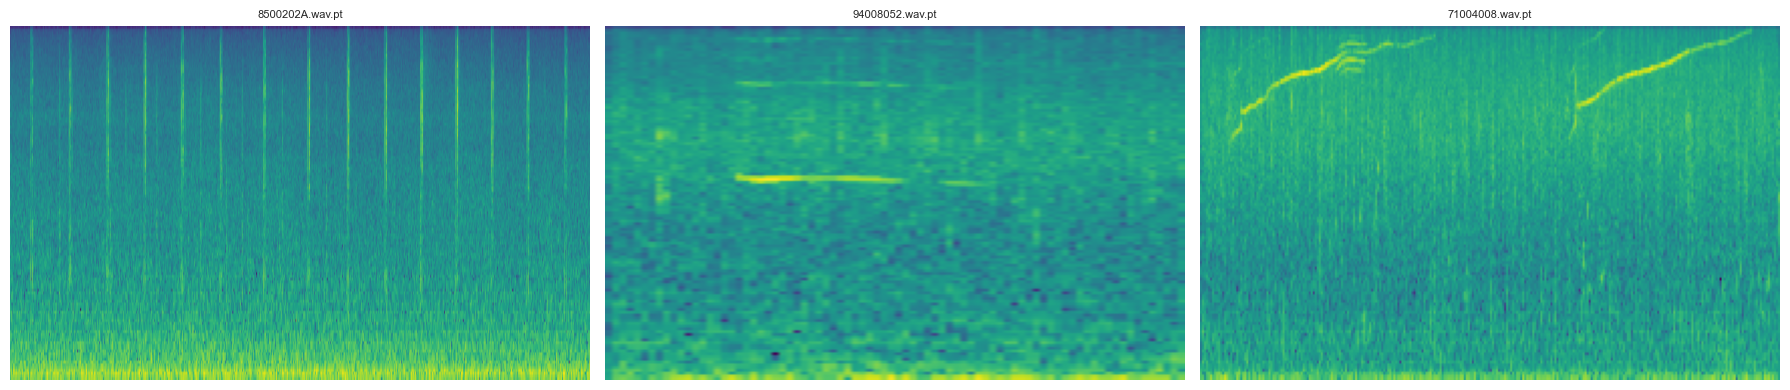

In [50]:
base_dir = ROOT_PATH / "Data" / "Spectrograms" / "train"

all_files = []
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".pt"):
            relative_path = os.path.join(root, f)
            all_files.append(relative_path)

if len(all_files) < 3:
    raise ValueError("Not enough .pt files found.")

# Select 3 random spectrograms
samples = random.sample(all_files, 3)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, path in zip(axes, samples):
    tensor = torch.load(path)

    species_name = os.path.basename(os.path.dirname(path))
    # Print the tensor shape and name
    print(f"{species_name} ---  shape: {tuple(tensor.shape)}")

    # Convert tensor to 2D for plotting
    if tensor.dim() == 2:
        img = tensor
    elif tensor.dim() == 3:
        # assume [C, H, W]
        img = tensor[0]  
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    ax.imshow(img.numpy(), aspect="auto", origin="lower", cmap="viridis")
    ax.set_title(os.path.basename(path), fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

## CNN

Dataloader

In [51]:
SPEC_ROOT = ROOT_PATH / "Data" / "Spectrograms"

# Use a larger batch size and enable in-memory cache for training if RAM allows
train_loader, val_loader, test_loader = get_dataloaders(
    SPEC_ROOT,
    batch_size=32,
    num_workers=4
)

## Training

In [52]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Baseline training
# trainer = Trainer(
#     spectrogram_dir=ROOT_PATH / "Data" / "Spectrograms",
#     checkpoint_path=ROOT_PATH / "baseline_best.pth",
#     model_name="baseline",
#     batch_size=32,
#     max_epochs=20,
#     lr=1e-3,
#     device=device,
# )
# trainer.fit()

In [53]:
# # EfficientNet training
# eff_trainer = Trainer(
#     spectrogram_dir=ROOT_PATH / "Data" / "Spectrograms",
#     checkpoint_path=ROOT_PATH / "efficientnet_best.pth",
#     model_name="efficientnet",
#     batch_size=32,
#     max_epochs=10,
#     lr=1e-4,
#     device=device,
# )
# eff_trainer.fit()

## Evaluate

Using checkpoint: ..\baseline_best_2.pth
Outputs already exist for baseline; skipping inference.
  ..\outputs\baseline_preds_v2.csv
  ..\outputs\baseline_misclassified_v2.csv
Using checkpoint: ..\efficientnet_best_2.pth
Outputs already exist for efficientnet; skipping inference.
  ..\outputs\efficientnet_preds_v2.csv
  ..\outputs\efficientnet_misclassified_v2.csv
Saved ..\outputs\analysis_plots\learning_curves_3.png
Saved ..\outputs\analysis_plots\baseline_classification_report_v2_precision_recall_1.png
Preds or test CSV not found: ..\outputs\baseline_preds_v2.csv Bens-Internship-Local\Data\Annotations\test.csv
Gallery skipped; missing preds/test/spectrograms


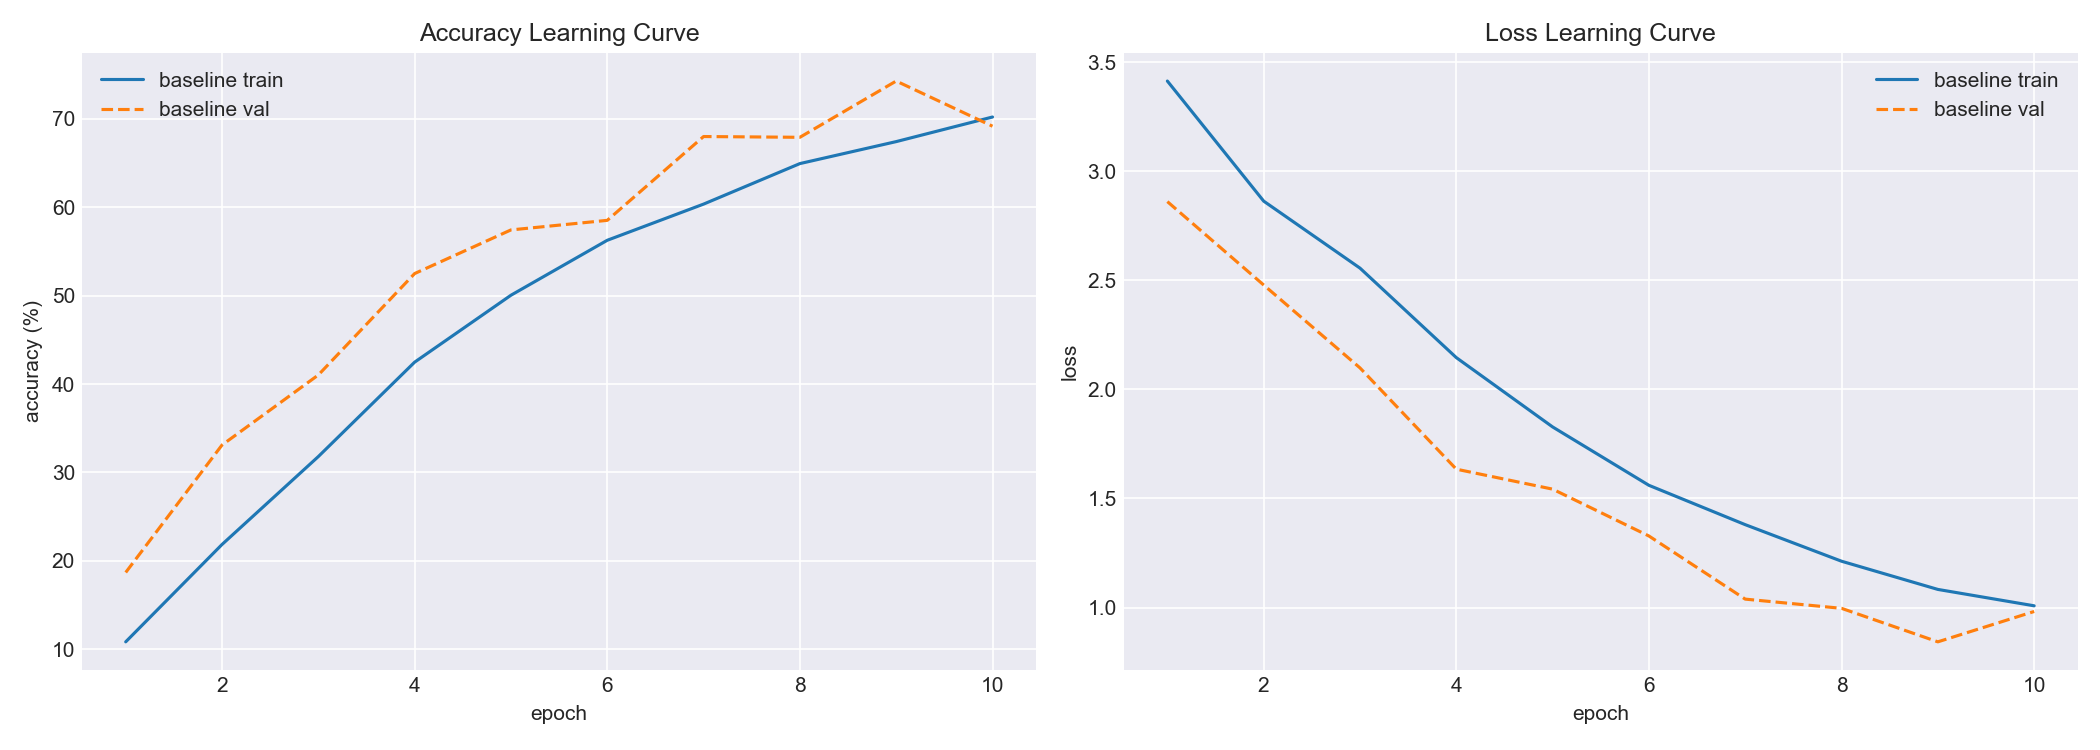

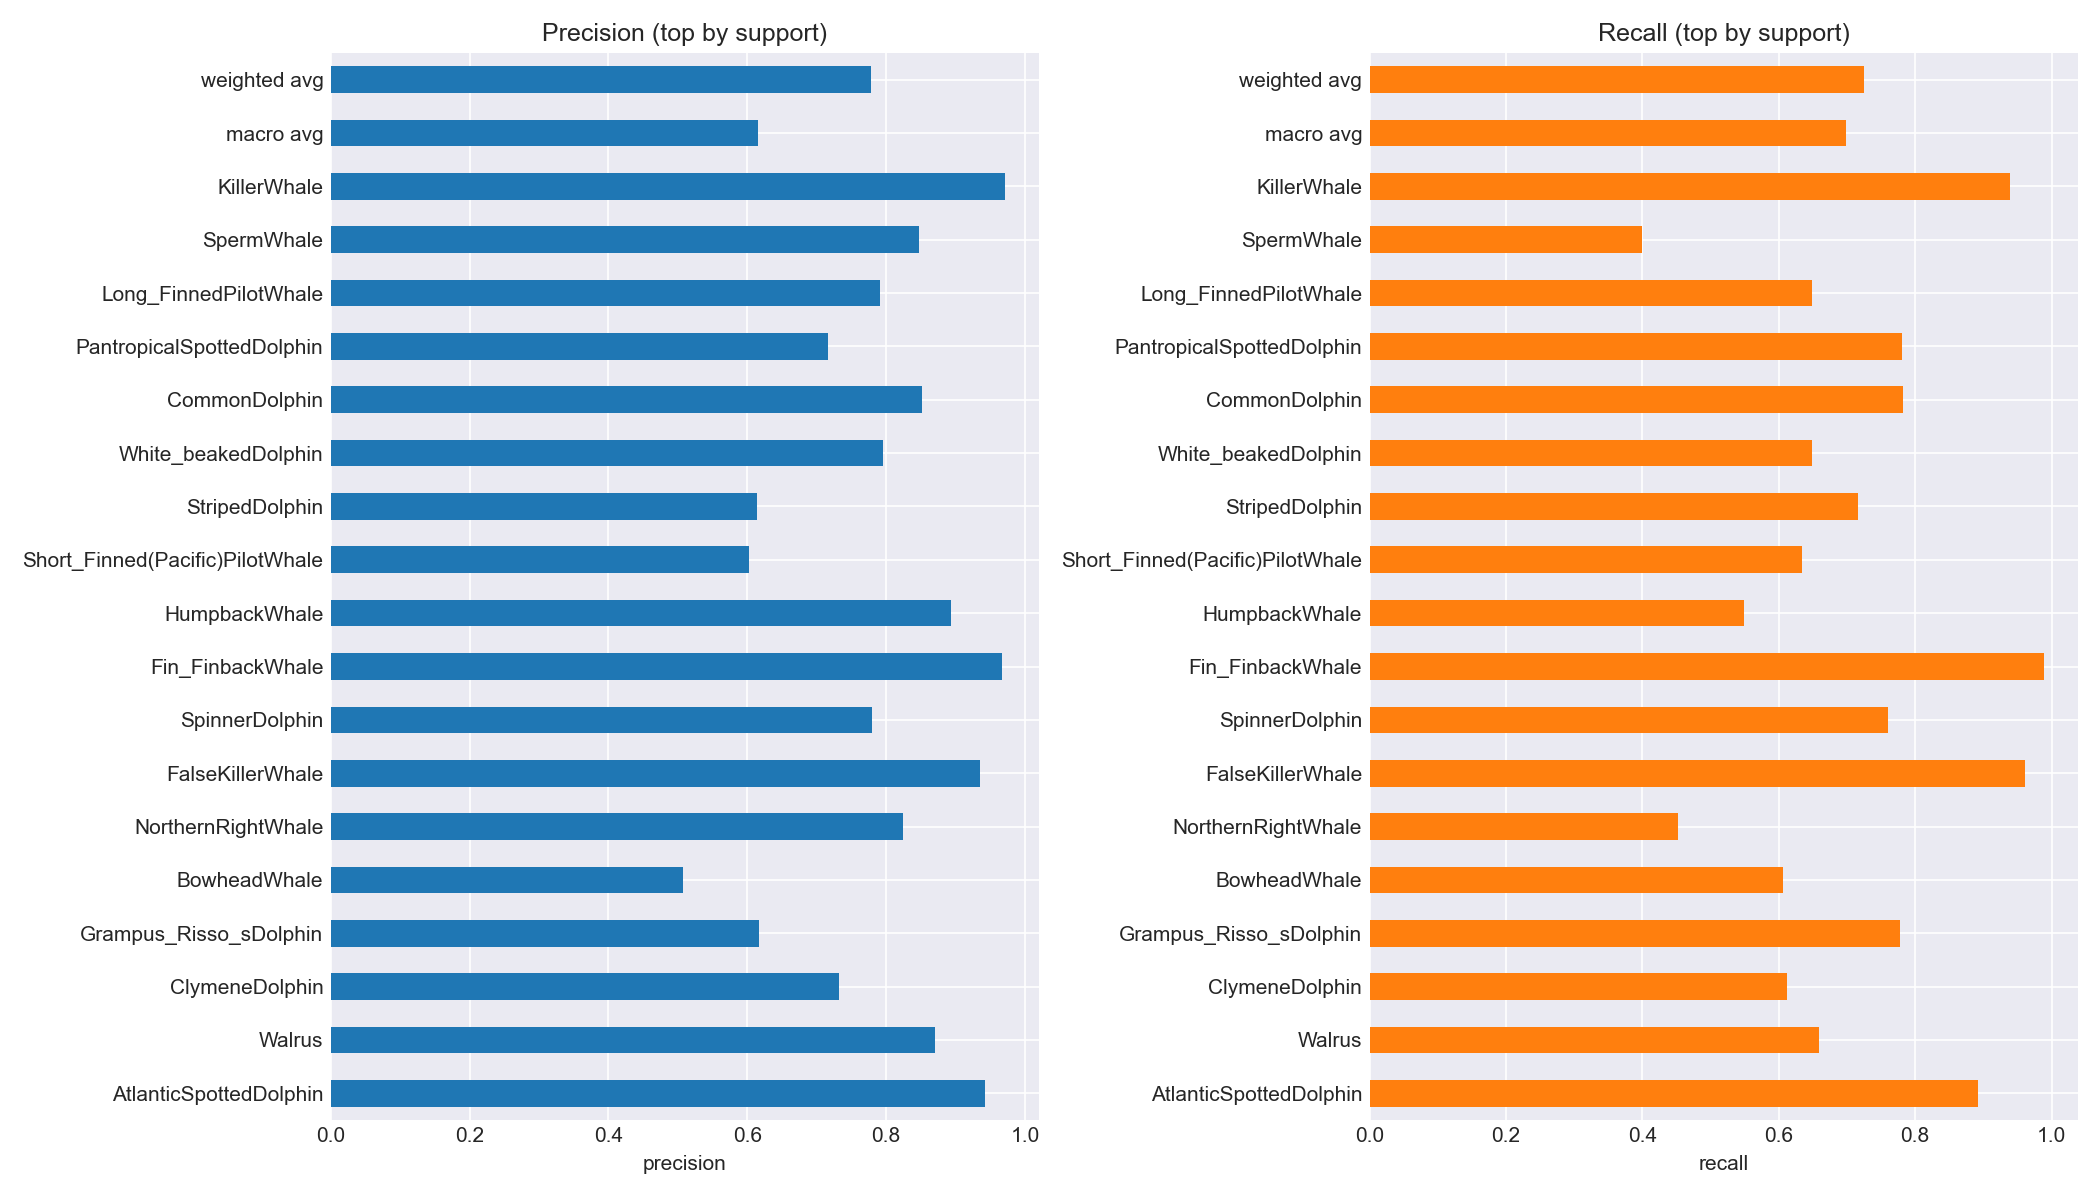

In [54]:
# Generate and display analysis charts: learning curves, precision/recall, strip plot, gallery
from pathlib import Path
import importlib.util
from IPython.display import display, Image
import torch
import torch.nn.functional as F

# Ensure ROOT_PATH (defined earlier cells) — fall back to notebook parent folder
try:
    ROOT_PATH
except NameError:
    ROOT_PATH = Path('..')

# load the plotting script from the repo relative `ROOT_PATH` (src/plot_analysis.py)
script_path = ROOT_PATH / "src" / "plot_analysis.py"
if not script_path.exists():
    raise FileNotFoundError(f"plot_analysis.py not found at {script_path}")
spec = importlib.util.spec_from_file_location('plot_analysis', str(script_path))
plot_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plot_mod)

# Paths (all relative to ROOT_PATH)
HISTORY = ROOT_PATH / 'baseline_best_training_history_2.csv'
REPORT = ROOT_PATH / 'outputs' / 'baseline_classification_report_v2.json'
PREDS = ROOT_PATH / 'outputs' / 'baseline_preds_v2.csv'
# test annotations are in the sibling folder `Bens-Internship-Local` at the workspace root
TEST_CSV = ROOT_PATH.parent.parent / 'Bens-Internship-Local' / 'Data' / 'Annotations' / 'test.csv'
SPECTROGRAMS = ROOT_PATH / 'Data' / 'Spectrograms'
OUT = ROOT_PATH / 'outputs' / 'analysis_plots'
OUT.mkdir(parents=True, exist_ok=True)

# 0) Evaluate models with v2 checkpoints (baseline_best_2.pth, efficientnet_best_2.pth)
from src.model import get_model

# test_loader should be defined earlier in the notebook; guard if not
try:
    test_loader
    num_classes = len(test_loader.dataset.classes)
    classes = list(test_loader.dataset.classes)
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
except NameError:
    test_loader = None
    num_classes = None
    classes = None
    DEVICE = "cpu"


def find_ckpt(preferred_name):
    p = ROOT_PATH / preferred_name
    if p.exists():
        return p
    # fallback: find newest matching pattern
    candidates = list(ROOT_PATH.glob(f'**/{preferred_name.replace("_2","*")}'))
    if candidates:
        candidates.sort(key=lambda x: x.stat().st_mtime, reverse=True)
        return candidates[0]
    return None


def run_inference_and_save(model_name, ckpt_path):
    """Run inference and save predictions/misclassifications only if outputs do not already exist.
    This prevents overwriting files on re-runs.
    """
    if test_loader is None:
        print('test_loader not available; skipping evaluation for', model_name)
        return

    out_preds = ROOT_PATH / 'outputs' / f'{model_name}_preds_v2.csv'
    out_mis = ROOT_PATH / 'outputs' / f'{model_name}_misclassified_v2.csv'

    # Do not overwrite existing outputs — skip if either file exists
    if out_preds.exists() or out_mis.exists():
        print(f'Outputs already exist for {model_name}; skipping inference.\n  {out_preds}\n  {out_mis}')
        return

    model = get_model(model_name, num_classes=num_classes, freeze_backbone=False)
    state = torch.load(str(ckpt_path), map_location=DEVICE)
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()

    y_true_all = []
    y_pred_all = []
    y_prob_max_all = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            probs = F.softmax(logits, dim=1).cpu()
            preds = probs.argmax(dim=1).cpu().numpy()
            y_true_all.extend(yb.numpy().tolist())
            y_pred_all.extend(preds.tolist())
            y_prob_max_all.extend(probs.max(dim=1).values.numpy().tolist())

    import pandas as pd
    df_pred = pd.DataFrame({'y_true': y_true_all, 'y_pred': y_pred_all, 'y_prob_max': y_prob_max_all})
    if classes is not None:
        df_pred['y_true_name'] = df_pred['y_true'].apply(lambda x: classes[x])
        df_pred['y_pred_name'] = df_pred['y_pred'].apply(lambda x: classes[x])

    # Save without overwriting (we already checked existence above)
    df_pred.to_csv(out_preds, index=False)
    print('Saved predictions to', out_preds)

    mis = df_pred[df_pred['y_true'] != df_pred['y_pred']]
    mis.to_csv(out_mis, index=False)
    print('Saved misclassified to', out_mis)

    # print simple metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    acc = accuracy_score(df_pred['y_true'], df_pred['y_pred'])
    prec, rec, f1, _ = precision_recall_fscore_support(df_pred['y_true'], df_pred['y_pred'], average='macro', zero_division=0)
    print(f"{model_name} -- acc: {acc:.4f}, prec_macro: {prec:.4f}, rec_macro: {rec:.4f}, f1_macro: {f1:.4f}")


# Run for baseline and efficientnet (v2) — will skip if outputs already present
for model_name in ['baseline', 'efficientnet']:
    ckpt_name = f'{model_name}_best_2.pth'
    ckpt = find_ckpt(ckpt_name)
    if ckpt is None:
        print('Checkpoint not found for', model_name, 'looking for', ckpt_name)
        continue
    print('Using checkpoint:', ckpt)
    run_inference_and_save(model_name, ckpt)

# 1) Learning curves
if HISTORY.exists():
    plot_mod.plot_learning_curves([HISTORY], ['baseline'], OUT)
else:
    print('History file not found:', HISTORY)

# 2) Precision / Recall bars
if REPORT.exists():
    plot_mod.plot_precision_recall_from_report(REPORT, OUT)
else:
    print('Report file not found:', REPORT)

# 3) Strip plot
if PREDS.exists() and TEST_CSV.exists():
    plot_mod.plot_strip_predictions(PREDS, TEST_CSV, OUT)
else:
    print('Preds or test CSV not found:', PREDS, TEST_CSV)

# 4) Gallery
if PREDS.exists() and TEST_CSV.exists() and SPECTROGRAMS.exists():
    plot_mod.gallery(PREDS, TEST_CSV, SPECTROGRAMS, OUT, mode='lowest', n=25)
else:
    print('Gallery skipped; missing preds/test/spectrograms')

# Display generated images (if any)
for img_name in ['learning_curves.png', (Path(REPORT).stem + '_precision_recall.png'), (Path(PREDS).stem + '_stripplot.png')]:
    img_path = OUT / img_name
    if img_path.exists():
        display(Image(filename=str(img_path)))
